# Onboarding Task 2: Object Detection Tutorial w/ Pytorch

### Purposed for the Pitt RAS Auto-Indy project to on-board new members to the perception sub-team. 
Authored by: Noah Gasparro, Thomas Detlefsen, Morgan Visnesky 
<br />
<br />
#### Description
Create an object detector in Google Colab using PyTorch. Filter and annotate the Indiana University dataset, format the dataset for the network, then create, train and test your network. Feel free to reach out to [PERSON/PEOPLE] for guidance on this task.


# Import  Libraries

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
%%shell

pip install cython # Needed for pycocotools

pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' # Install pycocotools, the version by default in Colab

# Upload and Import Dataset to Google Colab

In [ ]:
from PIL import Image # For image visualization
from google.colab import drive
import os

# Mount drive for importing
drive.mount("/content/drive", force_remount=True)

# Commands for navigating google drive
!ls "/content/drive/MyDrive/Perception/Perception_Onboarding"
os.chdir("/content/drive/MyDrive/Perception/Perception_Onboarding")
!unzip -q sample_dataset.zip

In [ ]:
# Test that directory is linked by opening image
Image.open('sample_dataset/images/100th_126.jpg')

# Format Data for CoCoTools

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


In [ ]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET

# make data csv file (https://github.com/experiencor/raccoon_dataset/blob/master/xml_to_csv.py)
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

image_path = os.path.join(os.getcwd(), 'sample_dataset/annotations')
xml_df = xml_to_csv(image_path)
xml_df.to_csv('car_labels.csv', index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [ ]:
labels = pd.read_csv("car_labels.csv") # Reads in csv w/ pandas
labels.head(5) # tests data format of first 5 rows is correct

In [ ]:
# From datafile and filename, pull bounding box coordinates
def parseDataFile(path_to_data_file, filename):
  data = pd.read_csv(path_to_data_file)
  boxes_array = data[data["filename"] == filename][["xmin", "ymin",
                                                    "xmax", "ymax"]].values
  return boxes_array

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root # Directory
        self.transforms = transforms # ...?
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.path_to_data_file = data_file

    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parseDataFile(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32) # Convert to tensor for pytorch operations

        num_objs = len(box_list)
        # Labels every object in image as 1 (we are only detecting race cars)
        labels = torch.ones((num_objs), dtype=torch.int64)
        image_id = torch.tensor([idx]) # Specifies image ID as tensor

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # Gets area of bounding box

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs), dtype=torch.int64)

        # Create a dictionary for image
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # If transform is specified, transform image
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

""" If import torch returns an error, restart runtime. This is a colab error """

In [ ]:
# Defining instance of CarDataset from local using car_labels.csv
dataset = CarDataset(root= 'sample_dataset/', 
                     data_file= 'car_labels.csv')

In [ ]:
 # if this line doesn't work or returns an error about .DS_store file, 
 # you can delete the DS_store file from your directories in your Gdrive and restart your colab notebook.
 # This should fix the error.
 dataset.__getitem__(0)

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

# Define Network

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load an instance segmentation model pre-trained on COCO  
def get_model(num_classes):
    # Get model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Write Helper Functions for Augmentation & Transformation


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms) # Combines all transforms

In [ ]:
# use our dataset and defined transformations
dataset = CarDataset(root= 'sample_dataset', 
                     data_file= 'car_labels.csv', 
                     transforms= get_transform(train=True))

dataset_test = CarDataset(root= 'sample_dataset', 
                          data_file= 'car_labels.csv', 
                          transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist() # Randomizes indices of images
dataset = torch.utils.data.Subset(dataset, indices[:-20]) # 80% of images
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:]) # 20 % of Images

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Instantiate Model & Train Network

In [ ]:
# Specify what device is running the network
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("# of GPUs: " + str(torch.cuda.device_count()))
  print("GPU name: " + str(torch.cuda.get_device_name(0)))
  print("Running on the GPU...")
else:
  device = torch.device("cpu")
  print("Running on the CPU...")

# our dataset has two classes only - background and car
num_classes = 2

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
retrain = True

# let's train it for 10 epochs
num_epochs = 10

if retrain == True:
  for epoch in range(num_epochs):
      # train for one epoch, printing every 10 iterations
      train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
      # update the learning rate
      lr_scheduler.step()
      # evaluate on the test dataset
      evaluate(model, data_loader_test, device=device)

# Test Network

In [ ]:
# saves the Car_Box_Detector model locally in your Gdrive
if retrain == True:
  PATH = "/content/drive/MyDrive/Perception/Perception_Onboarding/Car_Box_Detector.pt"
  torch.save(model, PATH)

In [ ]:

#if retrain == False:
import torch
from google.colab import drive

drive.mount("/gdrive")

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("# of GPUs: " + str(torch.cuda.device_count()))
  print("GPU name: " + str(torch.cuda.get_device_name(0)))
  print("Running on the GPU...")
else:
  device = torch.device("cpu")
  print("Running on the CPU...")

# Save Model
PATH = "/content/drive/MyDrive/Perception/Perception_Onboarding/Car_Box_Detector.pt"
model = torch.load(PATH)


In [ ]:
 PATH = "/content/drive/MyDrive/Perception/Perception_Onboarding/Car_Box_Detector.pt"
 model = torch.load(PATH)
 model.to(device)
 #model = get_model(num_classes=2)
 #model.load_state_dict(torch.load(PATH))


In [ ]:
import random

# pick one image from the test set
idx = random.randint(0, 19)
img, _ = dataset_test[idx]
img = img.to(device)
label_boxes = np.array(dataset_test[idx][1]["boxes"])
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

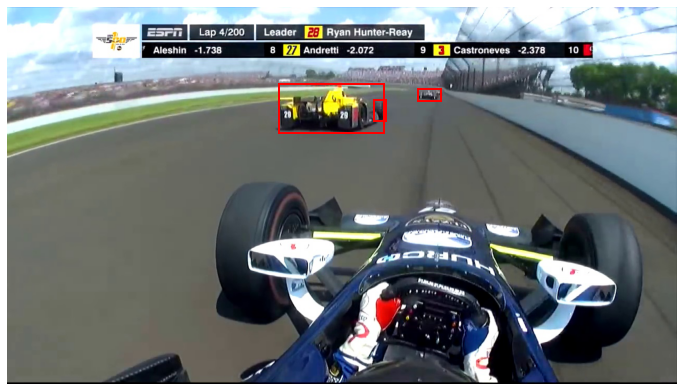

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = img.to('cpu')
new_image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
fig,ax = plt.subplots(1)
ax.imshow(new_image)
plt.rcParams["figure.figsize"] = [12,8]
plt.axis('off')

# superimpose 1st bounding box on image
picture = prediction[0]['boxes']

for box in picture:
  xmin = box[0]
  ymin = box[1]
  xmax = box[2]
  ymax = box[3]
  width = xmax - xmin
  height = ymax - ymin
  rect = patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()

# Citations

- https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae
- https://medium.com/@navneetkumar11/loading-image-data-from-google-drive-to-google-colab-using-pytorchs-dataloader-2e5617978a63
- https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc
- https://jovian.ai/aakanksha-ns/road-signs-bounding-box-prediction